In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alphabet/train.csv
/kaggle/input/alphabet/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for handling balancing of output classes in training sample data
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import NeighbourhoodCleaningRule
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

import tensorflow as tf
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.layers import Dropout

# for learning rate decay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

# loading gc for removing unused variables and clearing memory
import gc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **Alphabet Recognizer**
# Problem Statement
The input training dataset contains 28x28 pixel 297960 sample handwritten alphabets. It is represented by 784 features(columns) in the input dataset. The input dataset as well contains the target alphabet value (as numbers from 0..25) as a separate column ( in addition to 784 features columns).

The ask is to train a model and use it to predict handwritten alphabets for a test data set having 74490 sample images.
An output csv file is generated for test data set predictions using the best configured model.



# Solution Steps
This solution requires multi-class classification (26 alphabets). We have used a simple trial CNN to start with and we created a final CNN model after parameter tuning.
1. Read Data set
1. Examine Data set Properties
1. Inspecting the Dataframe
1. Data Preparation
    1. Copy Target Column(Alphabet) values and Remove from Training Data set
	1. Validate Training Sample size per Alphabet 
    1. Under sampling of Training dataset to balance class distribution Using NeighbourhoodCleaningRule
    1. Save the undersampled dataset


# Read Training Data set

In [3]:
#read training dataset
df_train = pd.read_csv('/kaggle/input/alphabet/train.csv')

# Examine Training Dataset Properties

In [4]:
#find the rows x columns
df_train.shape

(297960, 785)

# Inspecting the Dataframe


In [5]:
#see the first 10 rows
df_train.head(10)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#see the last 10 rows
df_train.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
297955,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297956,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297957,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297958,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297959,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preparation

  ### Copy Target Column(Alphabet) values and Remove from Training Data set


In [7]:
#create target variable y for the alphabet dataset
y_train = df_train['0']

#remove target column from the df_alpha
del df_train['0']

In [8]:
# Rename values
alphabet_y_train = y_train.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])


In [9]:
#view mapping 
alphabet_y_train

0         B
1         S
2         B
3         S
4         S
         ..
297955    S
297956    Y
297957    N
297958    O
297959    N
Name: 0, Length: 297960, dtype: object

 ### Validate Training Sample size per Alphabet 

<Figure size 1000x500 with 0 Axes>

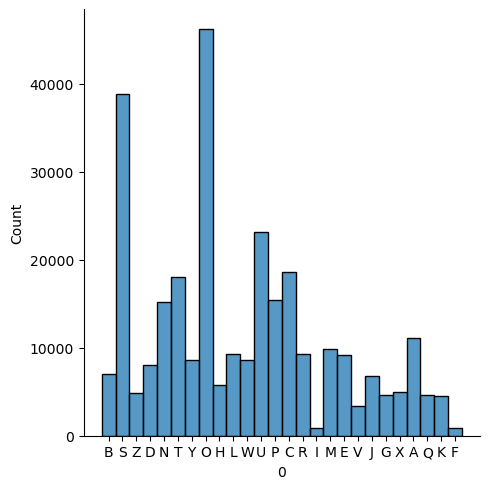

In [10]:
# Looking for imbalances in data
plt.figure(figsize = (10,5))
sns.displot(alphabet_y_train)

### Under sampling of Training dataset to balance class distribution

In [11]:
#undersample and balance samples per alphabet with NeighbourhoodCleaningRule
NCR = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_train_data, y_train_data = NCR.fit_resample(df_train, y_train)

#del df_train to save memory
del df_train
gc.collect()
X_train_data.to_csv('X_train_data.csv')
y_train_data.to_csv('y_train_data.csv')